# Colliders and Confounders

Let's generate two of the simplest non-trivial data structures, which is the collider and the confounder.

Verify that you can indeed get back the true answer.

### Confounder

Make a simple graph with a confounder

In [31]:
import sys
sys.path.append('../causal_faker')

from causal_faker import CausalFaker

import matplotlib.pyplot as plt

import numpy as np

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [3]:
plt.style.use('../../studge-master/misc/plotting/default.mplstyle')

I add noise for every node, so there are infact 5 nodes. I am interested in the effects of 3 on 4.

I'll first do the case where there is actually no causal link between our two nodes of interest, but there is a confounder.

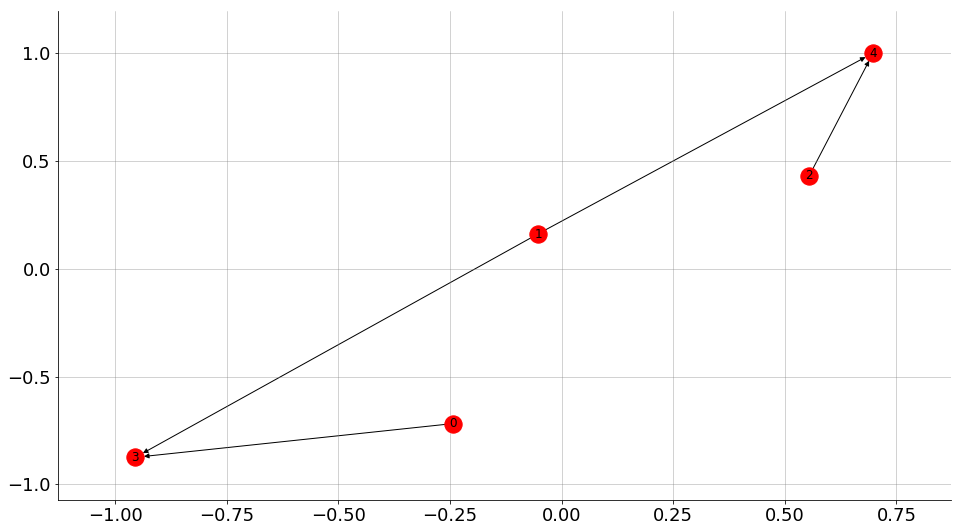

In [4]:
structure = {
    (0, 3): .2,
    (1, 3): 0.4,
    (1, 4): 0.6,
    (2, 4): 0.3
}

cf = CausalFaker(structure)
cf.draw()

The picture is not always exactly how we might imagine it, but the idea is clear I think.

Make some data based on this, we can make quite a lot, so that we get a pretty clear signal.

In [5]:
data = cf.get_df(50000)
data.head()

,0,1,2,3,4
0,0.994237,-0.720232,0.448853,-0.089246,-0.297484
1,1.277234,-0.088670,2.204211,0.219979,0.608061
2,1.089050,0.579481,-0.396345,0.449602,0.228785
3,-1.041375,-0.254251,1.122077,-0.309976,0.184072
4,-0.016866,-0.738198,-1.319567,-0.298653,-0.838789


Now recall that our model specified no relationship between 3 and 4, is this what we see in the data?

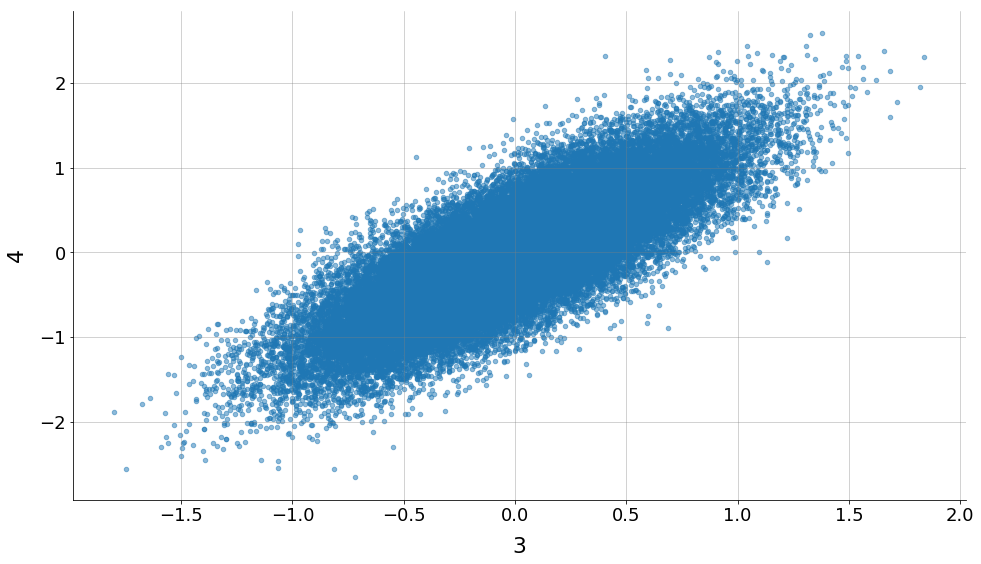

In [6]:
data.plot.scatter(3, 4, alpha=0.5)

Clearly from simply looking at the data they are strongly correlated.

We can look at all pairs of variables.

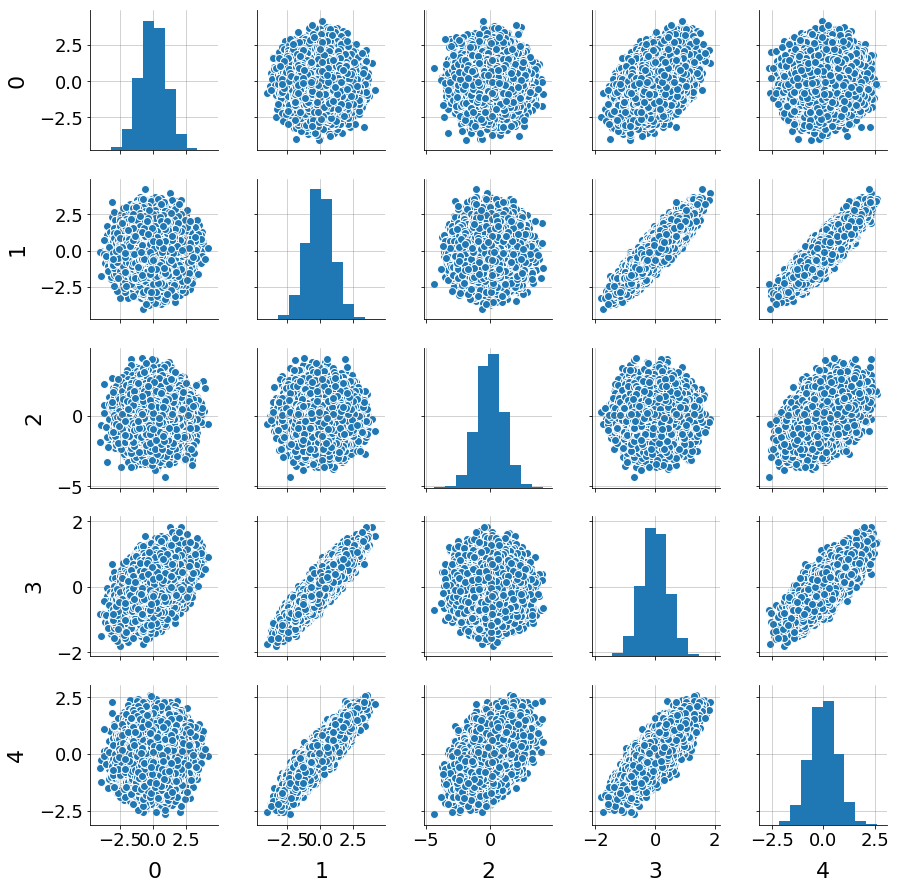

In [7]:
from seaborn import pairplot
pairplot(data)

Now how do we estimate the real effect of 3 on 4.

The answer is to perform a regression.

In [8]:
from sklearn.linear_model import LinearRegression as LR

Let's first see what happens if we ignore the confounder.

In [9]:
lr = LR()
X, Y = data[[3]], data[4]
lr.fit(X, Y)
lr.score(X, Y)

0.6397989801493557

In [10]:
lr.coef_

array([1.19727716])

And what happens now when we do this with the counfounder.

In [11]:
X, Y = data[[1, 3]], data[4]
lr.fit(X, Y)
lr.score(X, Y)

0.7990441586705376

This is pretty close to what we speciffied, (0.6 and zero respectivley)

In [12]:
lr.coef_

array([0.59739213, 0.00461228])

Note that it will depend on how much data you give it, but we have a point estimate for the true values.

Let's put this into a function so that we can play with it a bit more.

In [13]:
def simple_counfounder(c1, c2=0, n=1000):
    
    structure = {
        (0, 3): .2,
        (1, 3): .3,
        (1, 4): c1,
        (2, 4): 0.3,
        (3, 4): c2
    }

    cf = CausalFaker(structure)
    data = cf.get_df(n)

    X, Y = data[[1, 3]], data[4]
    lr.fit(X, Y)
    lr.score(X, Y)
    
    return tuple(lr.coef_)


In [14]:
simple_counfounder(0.3, 0.1, n=50000)

(0.29861956677317825, 0.09908484564937296)

Let's see how we estimate the true effect with the size of the trail.

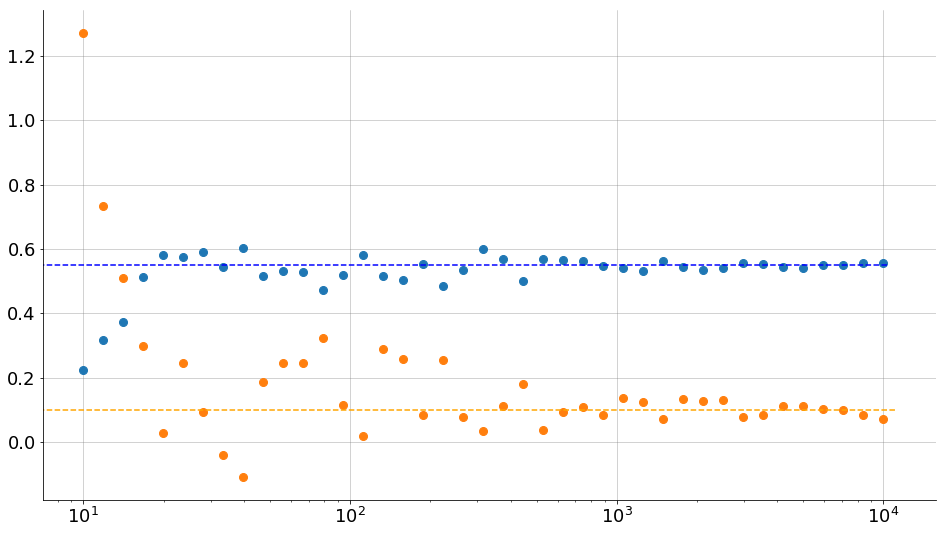

In [15]:
ns = np.logspace(1, 4, 41)
c1, c2 = 0.55, 0.1
coefs = np.array([simple_counfounder(c1, c2, n=int(n)) for n in ns])
ax = plt.subplot()
ax.plot(ns, coefs, 'o')
ax.plot(ax.get_xlim(), [c1]*2, '--', color='blue')
ax.plot(ax.get_xlim(), [c2]*2, '--', color='orange')
ax.set_xscale('log')

Note that this is also this module that is recommended. It should do the same thing in principle.

In [16]:
import statsmodels.formula.api as smf
smf.ols

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

Note that for this function we must pass a formula as a string, but numbers as names don't work.



In [17]:
data = data.rename(columns={
    4: 'y',
    3: 'x',
    1: 'z1'
}
)

In [18]:
lr = smf.ols(formula='y ~ x + z1', data=data)
lr.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                 9.940e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:38   Log-Likelihood:                -10730.
No. Observations:               50000   AIC:                         2.147e+04
Df Residuals:                   49997   BIC:                         2.149e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0021      0.001     -1.548      0.122      -0.005       0.001
x              0.0046      0.007      0.688      0.491      -0.009       0.018
z1             0.5974      0.003    199.047      0.000       0.592       0.603
==============================================================================
Omnibus:                        5.766   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.753
Skew:                           0.024   Prob(JB):                       0.0563
Kurtosis:                       3.021   Cond. No.                         5.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that this version is much better, it goes one step further and gives you probability bounds. Note that the coefficient that we are interested in is consistent with being zero `alpha=0.05`

### Collider

Let's make another simple example, in which we have a collider. This is similar to what we had, except for the fact that the edges are reversed in this case.

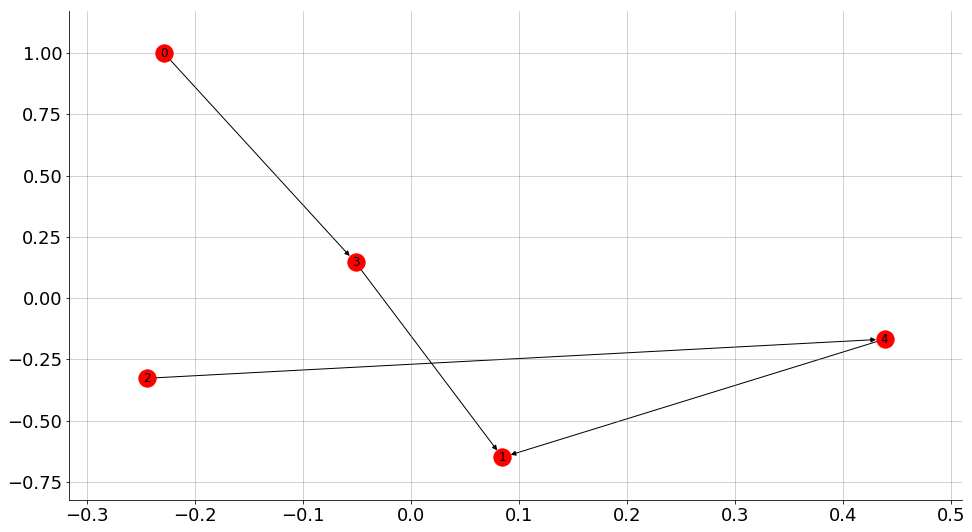

In [19]:
structure = {
    (0, 3): .2,
    (3, 1): 0.4,
    (4, 1): 0.6,
    (2, 4): 0.3
}

cf = CausalFaker(structure)
cf.draw()

Again make the data, and again measure the correlations.

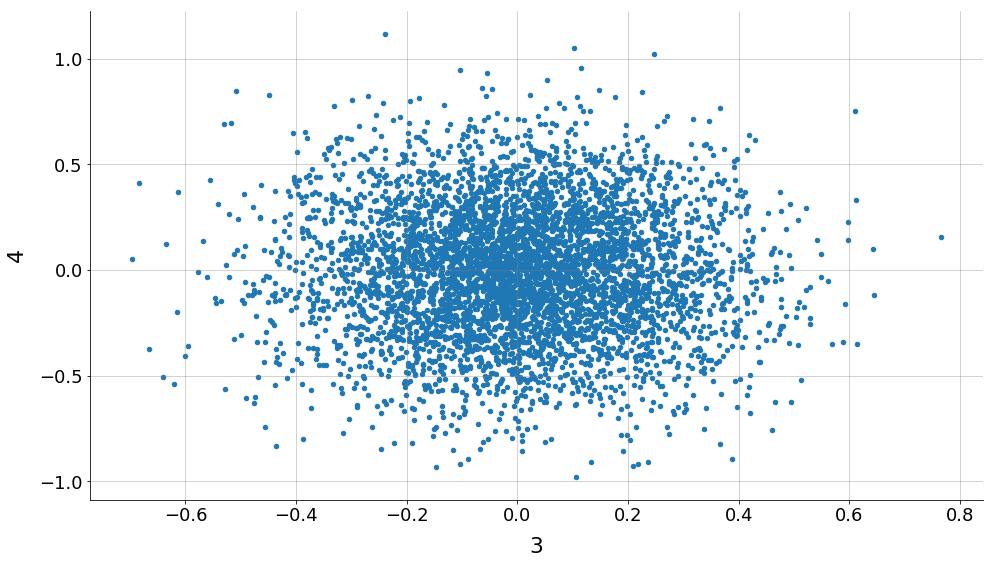

In [20]:
data = cf.get_df(5000)
data.plot.scatter(3, 4)

Now they are not correlated strongly.

Let's verify that this is indeed the case that our data is consistent with zero correlation.

In [21]:
data = data.rename(columns={
    4: 'y',
    3: 'x',
    1: 'z1'
})

What is the correlation for the simple model without including the collider?

In [22]:
smf.ols(formula='y ~ x', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.035
Date:                Mon, 25 Nov 2019   Prob (F-statistic):              0.309
Time:                        15:14:40   Log-Likelihood:                -1120.6
No. Observations:                5000   AIC:                             2245.
Df Residuals:                    4998   BIC:                             2258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.004     -0.392      0.695      -0.010       0.007
x             -0.0220      0.022     -1.017      0.309      -0.065       0.020
==============================================================================
Omnibus:                        0.742   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.690   Jarque-Bera (JB):                0.785
Skew:                          -0.017   Prob(JB):                        0.675
Kurtosis:                       2.949   Cond. No.                         5.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Which is indeed consitent with there being no correlation between x and y.

Do we get the right correlation between x and y and z1.

In [23]:
smf.ols(formula='z1 ~ y', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     z1   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 2.607e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:41   Log-Likelihood:                 5593.3
No. Observations:                5000   AIC:                        -1.118e+04
Df Residuals:                    4998   BIC:                        -1.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.001      0.321      0.748      -0.002       0.003
y              0.5962      0.004    161.448      0.000       0.589       0.603
==============================================================================
Omnibus:                        0.867   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.648   Jarque-Bera (JB):                0.814
Skew:                          -0.017   Prob(JB):                        0.666
Kurtosis:                       3.053   Cond. No.                         3.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
smf.ols(formula='z1 ~ x', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     z1   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     885.2
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          3.06e-179
Time:                        15:14:41   Log-Likelihood:                 1433.5
No. Observations:                5000   AIC:                            -2863.
Df Residuals:                    4998   BIC:                            -2850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.003     -0.392      0.695      -0.006       0.004
x              0.3868      0.013     29.753      0.000       0.361       0.412
==============================================================================
Omnibus:                        0.742   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.690   Jarque-Bera (JB):                0.785
Skew:                          -0.017   Prob(JB):                        0.675
Kurtosis:                       2.949   Cond. No.                         5.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These are both consitent with the actual number I gave the graph.

In [25]:
cf.pretty_print_equation()

x_0 = N(0, 1)
x_1 = 0.400*x_3 + 0.600*x_4
x_2 = N(0, 1)
x_3 = 0.200*x_0
x_4 = 0.300*x_2


Now what happens if we control for the counfounder.

In [26]:
smf.ols(formula='y ~ x + z1', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.921e+33
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:14:42   Log-Likelihood:             1.7270e+05
No. Observations:                5000   AIC:                        -3.454e+05
Df Residuals:                    4997   BIC:                        -3.454e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.795e-18   3.42e-18     -1.110      0.267   -1.05e-17    2.91e-18
x             -0.6667   1.88e-17  -3.55e+16      0.000      -0.667      -0.667
z1             1.6667   1.88e-17   8.85e+16      0.000       1.667       1.667
==============================================================================
Omnibus:                       13.426   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.149
Skew:                           0.072   Prob(JB):                     0.000513
Kurtosis:                       3.228   Cond. No.                         6.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now it has given us a strongly non-zero answer! Which is actually not true!

Moral of the story, control for a confounder, but not for a collider.

How do you know which is which, only with domain knowledge and making a model of your data (or doing an experiment).

### Other

As an asside, what would the correlation of x on y be if we had knew how both correlated with their confounder.

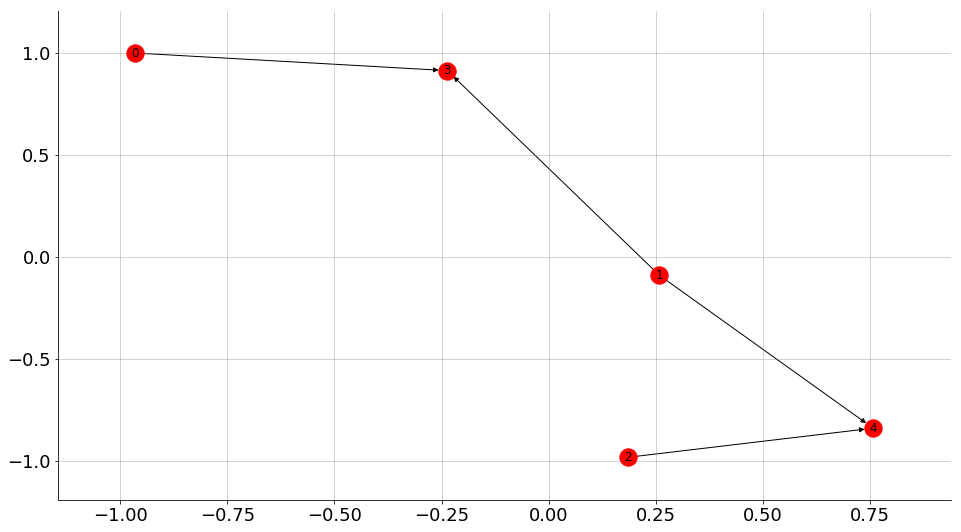

In [27]:
structure = {
    (0, 3): .15,
    (1, 3): 0.4,
    (1, 4): 0.66,
    (2, 4): 0.5
}

cf = CausalFaker(structure)
cf.draw()

In [28]:
data = cf.get_df(100000)

In [29]:
cf.pretty_print_equation()

x_0 = N(0, 1)
x_1 = N(0, 1)
x_2 = N(0, 1)
x_3 = 0.150*x_0 + 0.400*x_1
x_4 = 0.660*x_1 + 0.500*x_2


In [32]:
x, y = data[[3]], data[4]
lr = LinearRegression()
lr.fit(x, y)
lr.coef_

array([1.44582673])

In [33]:
a, b, c, d = 0.15, 0.4, 0.66, 0.5
c/b

1.65

Not sure how this works, but maybe it is not that important, come back to it.

### Chains

What does this give us?

Do we get the right answer directly from this, or do we need to control something.

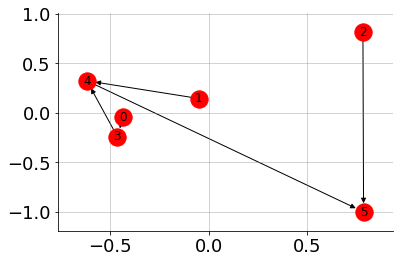

In [34]:
structure = {
    (0, 3): 0.2,
    (1, 4): 0.3,
    (2, 5): -0.1,
    (3, 4): 0.4,
    (4, 5): -0.8
}

cf = CausalFaker(structure)
cf.draw()

3, 4, 5 cause a chain, and 0, 1, and 2 add noise to these nodes.

In [35]:
data = cf.get_df(10000, True)
data.head()

,x_0,x_1,x_2,x_3,x_4,x_5
0,0.571734,-0.090596,0.369599,0.114347,0.018560,-0.051808
1,-2.409137,-0.752460,1.025217,-0.481827,-0.418469,0.232253
2,0.206341,-1.404859,-1.454944,0.041268,-0.404950,0.469455
3,0.620615,0.815040,0.144741,0.124123,0.294161,-0.249803
4,-0.183530,0.628984,0.691455,-0.036706,0.174013,-0.208356


In [36]:
smf.ols('x_5 ~ x_4', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_5   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 6.101e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:34   Log-Likelihood:                 8800.3
No. Observations:               10000   AIC:                        -1.760e+04
Df Residuals:                    9998   BIC:                        -1.758e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.001     -0.228      0.820      -0.002       0.002
x_4           -0.8009      0.003   -246.993      0.000      -0.807      -0.795
==============================================================================
Omnibus:                        4.074   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                4.269
Skew:                          -0.016   Prob(JB):                        0.118
Kurtosis:                       3.096   Cond. No.                         3.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
smf.ols('x_5 ~ x_4 + x_3', data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_5   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 3.050e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:35   Log-Likelihood:                 8800.8
No. Observations:               10000   AIC:                        -1.760e+04
Df Residuals:                    9997   BIC:                        -1.757e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.001     -0.250      0.803      -0.002       0.002
x_4           -0.8000      0.003   -239.188      0.000      -0.807      -0.793
x_3           -0.0052      0.005     -0.995      0.320      -0.015       0.005
==============================================================================
Omnibus:                        4.032   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                4.223
Skew:                          -0.016   Prob(JB):                        0.121
Kurtosis:                       3.096   Cond. No.                         5.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We actually get the right answer regardless of whether we condition on 3 or not.

### Instrumental Variables

This is the same confounder case as we had before, but in addition there is another variable that has causes x only.

In addition, we assume that we can't measure the confounding effect.

How can we estimate the true effect in this case?

Start with the confounder like we had before. But add one more variable.

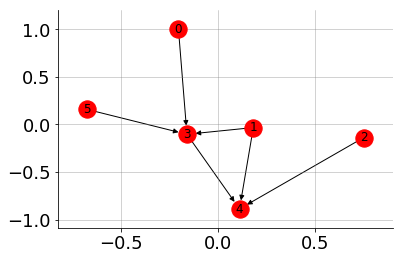

In [38]:
structure = {
    (0, 3): .2,
    (1, 3): 0.4,
    (1, 4): 0.6,
    (2, 4): 0.3,
    (3, 4): 0.8,   # For this example assume there is some real effect
    (5, 3): 0.7    # This is my instrumental variable.
}

cf = CausalFaker(structure)
cf.draw()

5 is the instrument.

The answer we are looking for is 0.8, what about if we do the naive method ...

In [39]:
data = cf.get_df(10000, True)
data.head()

,x_0,x_1,x_2,x_5,x_3,x_4
0,1.783396,-0.284493,0.575605,-0.101929,0.171532,0.139211
1,1.096352,1.838999,-0.710496,1.158123,1.765556,2.302696
2,-0.887045,-0.395064,-2.117268,-1.305655,-1.249393,-1.871733
3,0.293688,0.978974,1.667000,-0.859828,-0.151552,0.966243
4,0.801248,0.926269,-0.944620,1.536784,1.606506,1.557580


In [40]:
smf.ols('x_4 ~ x_3', data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_4   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                 2.432e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:42   Log-Likelihood:                -9242.1
No. Observations:               10000   AIC:                         1.849e+04
Df Residuals:                    9998   BIC:                         1.850e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.006     -0.439      0.661      -0.015       0.009
x_3            1.1472      0.007    155.946      0.000       1.133       1.162
==============================================================================
Omnibus:                        3.614   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.608
Skew:                          -0.035   Prob(JB):                        0.165
Kurtosis:                       3.061   Cond. No.                         1.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not right! Which we expected.

Let's check we get back the same answer once if we control for the confounder, although we said in the setup we are pretending that we can't measure it, this is a sanity check.

In [41]:
cf.pretty_print_equation()

x_0 = N(0, 1)
x_1 = N(0, 1)
x_2 = N(0, 1)
x_3 = 0.200*x_0 + 0.400*x_1 + 0.700*x_5
x_4 = 0.600*x_1 + 0.300*x_2 + 0.800*x_3
x_5 = N(0, 1)


In [42]:
smf.ols('x_4 ~ x_3 + x_1', data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_4   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 6.628e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:46   Log-Likelihood:                -2121.0
No. Observations:               10000   AIC:                             4248.
Df Residuals:                    9997   BIC:                             4270.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0062      0.003     -2.058      0.040      -0.012      -0.000
x_3            0.8029      0.004    195.946      0.000       0.795       0.811
x_1            0.5983      0.003    177.584      0.000       0.592       0.605
==============================================================================
Omnibus:                        4.172   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                3.927
Skew:                           0.011   Prob(JB):                        0.140
Kurtosis:                       2.905   Cond. No.                         1.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We do indeed get the right answer.

But now we assume that we can't measure 1. Can we still get the right answer.

Conditioning on 1 won't help, and this is effectively a chain that we saw above.

In [43]:
smf.ols('x_4 ~ x_3 + x_5', data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_4   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 3.481e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:46   Log-Likelihood:                -5033.9
No. Observations:               10000   AIC:                         1.007e+04
Df Residuals:                    9997   BIC:                         1.010e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0040      0.004     -1.004      0.315      -0.012       0.004
x_3            2.0054      0.009    225.441      0.000       1.988       2.023
x_5           -0.8445      0.007   -114.881      0.000      -0.859      -0.830
==============================================================================
Omnibus:                        1.335   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                1.347
Skew:                          -0.010   Prob(JB):                        0.510
Kurtosis:                       2.947   Cond. No.                         3.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However, there is a way ...

We estimate the effects of our instrement on our dependent varialbe first of all.

In [44]:
m1 = smf.ols('x_4 ~ x_5', data).fit()

Changing x_5 by one unit induces a change of 0.55 units on x_4 ...

In [45]:
m1.params['x_5']

0.5471617652460449

Do the same for x_3 and x_5

In [46]:
m2 = smf.ols('x_3 ~ x_5', data).fit()
m2.params['x_5']

0.6939615573810317

And changing 5 by one changes 3 by 0.69 (which is the number that we provided as nothing confounds these two guys), so by extension:

In [47]:
m1.params['x_5']/m2.params['x_5']

0.7884612042646855

Which is pretty close to our original answer right?

Note that this only works because there are not confounders between 5 and 4, and also none-between 5 and 3, so these are true estimates. There is a confounder between 3 and 4, which is why the simplest thing does not work.

The notes also mention the case of more than one instrumental variable.
In theory you can get an estimate from just one, but it might be more accurate to use both.

What you do here is you do a regression of x on all of your instruments.

Then you do another regression of your dependent variable on the outcome of the first regression.

Looks like there is a function to do this in python, [here](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.regression.gmm.IV2SLS.html)

There is also some code to do it in the causal inference notebook, which doesn't use the above function.

Note that the general technique is called 2 stage least squared.

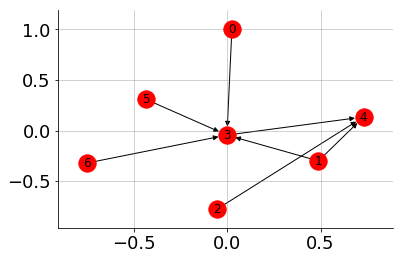

In [48]:
structure = {
    (0, 3): .2,
    (1, 3): 0.4,
    (1, 4): 0.6,
    (2, 4): 0.3,
    (3, 4): 0.8,   # For this example assume there is some real effect
    (5, 3): 0.7,    # This is my instrumental variable.
    (6, 3): 0.45   # This is the second one
}

cf = CausalFaker(structure)
cf.draw()

In [49]:
data = cf.get_df(10000, True)
data.head()

,x_0,x_1,x_2,x_5,x_6,x_3,x_4
0,-0.038510,-0.917753,0.425807,1.115628,0.326680,0.553142,0.019604
1,-1.495218,2.178450,1.053214,0.427892,0.650716,1.164683,2.554781
2,-0.078341,-1.432783,1.104740,0.019700,0.012354,-0.569431,-0.983793
3,-1.098918,-0.810151,0.080102,-0.249429,0.290161,-0.587872,-0.932357
4,-0.269261,-0.709660,1.644842,0.182623,-1.497584,-0.883793,-0.639378


In [50]:
# This is the model that predicts x based on the instrument variables.
m1 = smf.ols('x_3 ~ x_6 + x_5', data).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_3   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                 1.740e+04
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:51   Log-Likelihood:                -6122.6
No. Observations:               10000   AIC:                         1.225e+04
Df Residuals:                    9997   BIC:                         1.227e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.004      0.455      0.649      -0.007       0.011
x_6            0.4520      0.004    101.585      0.000       0.443       0.461
x_5            0.6980      0.004    156.514      0.000       0.689       0.707
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.161
Skew:                          -0.008   Prob(JB):                        0.923
Kurtosis:                       3.012   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that they say an F-statistic less than 10 will give a shity estimate.

In [51]:
import statsmodels.api as sm

In [52]:
# This will be a list of values that were predicted for my equation
Xhat = m1.fittedvalues

# The code says I have to do this, not sure what the point is
Xhat = sm.add_constant(Xhat)

m8 = sm.OLS(data.x_4, Xhat).fit()

beta = m8.params[0]
beta

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


0.8055367493429177

In [53]:
Xhat

,const,0
0,1.0,0.928448
1,1.0,0.594835
2,1.0,0.021368
3,1.0,-0.040932
4,1.0,-0.547373
...,...,...
9995,1.0,-0.768674
9996,1.0,0.179926
9997,1.0,1.206038
9998,1.0,0.905966


In [54]:
m8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    x_4   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     4692.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:15:54   Log-Likelihood:                -13978.
No. Observations:               10000   AIC:                         2.796e+04
Df Residuals:                    9998   BIC:                         2.798e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.010      0.374      0.708      -0.016       0.023
0              0.8055      0.012     68.501      0.000       0.782       0.829
==============================================================================
Omnibus:                        0.152   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.927   Jarque-Bera (JB):                0.171
Skew:                          -0.007   Prob(JB):                        0.918
Kurtosis:                       2.986   Cond. No.                         1.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I'm curious as to what the effects are to adding the other instrument, presumably it makes the estimate more accurate. Let's have a look at this.

In [55]:
def two_estimates(n, c=0.8):
    """
    Get the estimates for using one and two variables
    respectively.
    """
    
    structure = {
        (0, 3): .2,
        (1, 3): 0.4,
        (1, 4): 0.6,
        (2, 4): 0.3,
        (3, 4): c,      # This is what we want to estimate.
        (5, 3): 0.1,    # This is my instrumental variable.
        (6, 3): 0.1    # This is the second one
    }

    cf = CausalFaker(structure)
    data = cf.get_df(n, True)
    
    # Predict x with one and two intstramental variables respectively
    m1 = smf.ols('x_3 ~ x_5', data).fit()  
    m2 = smf.ols('x_3 ~ x_6 + x_5', data).fit()
    
    # Now do the two predictions of the true effect in each case.
    
    Xhat1 = m1.fittedvalues
    Xhat2 = m2.fittedvalues
    
    Xhat1 = sm.add_constant(Xhat1)
    Xhat2 = sm.add_constant(Xhat2)


    m3 = sm.OLS(data.x_4, Xhat1).fit()
    m4 = sm.OLS(data.x_4, Xhat2).fit()

    return m3.params[0], m4.params[0]
    

And make two histograms based on this.

In [56]:
import pandas as pd

In [57]:
data = pd.DataFrame([two_estimates(1000) for _ in range(1000)])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


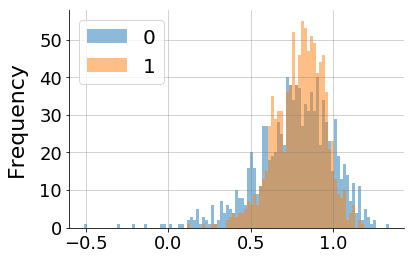

In [58]:
data.plot.hist(alpha=0.5, bins=101)

In [59]:
data.describe()

,0,1
count,1000.000000,1000.000000
mean,0.766991,0.797411
std,0.231338,0.150614
min,-0.511330,0.111772
25%,0.637740,0.697434
50%,0.786172,0.812950
75%,0.926166,0.906969
max,1.337299,1.175202


Seems to be better?